Name: Jui-Yang (Ray) Wang

student ID: 8552258069

In [ ]:
#2022 AME508 assignment_2

import torch
import random
import numpy as np
import torch.nn as nn
from torch.nn import Tanh as tanh
import torch.nn.functional as f
from numpy.core.function_base import linspace
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Q2

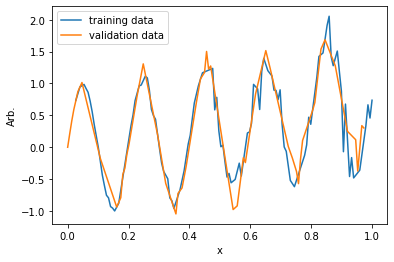

In [ ]:
# fix random seed to ensure reproducibility, ref(https://clay-atlas.com/blog/2020/09/26/pytorch-cn-set-random-seed-reproduce-result/)
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# starting the spacing in x dir and plotting function
x = torch.linspace(0,1,steps=150)
random.shuffle(x.numpy())
x_train = x[:100]
x_test = x[100:]


x_train = torch.sort(x_train)[0]
x_test = torch.sort(x_test)[0]

def function(var):
  # true function
  y = var**2 + torch.sin(10*torch.pi*var.clone().detach()) + 0.3*var*torch.normal(0, 1, size=var.size())

  return y


target_train = function(x_train)
target_test = function(x_test)

plt.plot(x_train, target_train)
plt.plot(x_test, target_test)
plt.legend(['training data','validation data'])
plt.xlabel('x')
plt.ylabel('Arb.')

plt.show()

Q3 define dataset

In [ ]:
#@title
from torch.utils.data import Dataset
# create dataset

class Mydataset(Dataset):
  
  # data loading, store them as class objects
  def __init__(self, x, function):
    # read training data, global variables, functions for the rest of class
    self.x = x
    self.function = function

  # working for inxdexing, return the sample pairs
  def __getitem__(self, idx):    
    return self.x[idx], self.function[idx]

  # return the length of the dataset: length of samples
  def __len__(self):
    return len(self.x)
  
# dataset = Mydataset(x, function(x))
# first_data = dataset[0:10]
# print(first_data[1])

Q4 define dataloader

In [ ]:
# create a dataset for training data
# dataloader is to extract data from dataset.
from torch.utils.data import DataLoader

dataset_train = Mydataset(x_train, target_train)
dataset_test = Mydataset(x_test, target_test)

# Epoch: one epoch means 1 forward and backward pass of all training samples
# Batch: number of samples used in one forward and backward pass
# iterations: number of passes used in one Epoch
# like 100 samples, when batch size is 20, then there will be 5 iterations in each epoch.

training_data = DataLoader(dataset=dataset_train, batch_size=50, shuffle=True, num_workers=0, drop_last=False)
testing_data = DataLoader(dataset=dataset_test, batch_size=50, shuffle=True, num_workers=0, drop_last=False)
# for data in testing_data:
#   item, function = data
#   print(item.shape)
#   print(function.shape)


Load the neural net work done from the first assignment

In [ ]:
# call in the function from assignment 1.

class neuralnetwork(nn.Module):                                                 # here we inherit Module as the basis of our ML code.
    def __init__(self, input_dim, width, output_dim, depth, activation="tanh"): # preset the activation function as tanh
        super().__init__()
        self.activation = activation                                            # need activation function in method part.
        
        self.mlp = nn.ModuleList()                                              # apply modulelist here, sequential can also be applied. 
        for i in range(depth):
            if i == 0:                                                          # first layer
                fc = nn.Linear(input_dim, width)                                
            elif i == depth - 1:                                                # last layer
                fc = nn.Linear(width, output_dim)                               
            else:                                                               # all hidden layers, the size should be width*width
                fc = nn.Linear(width, width)
          

            nn.init.uniform_(fc.weight, a=-1, b=1)
            self.mlp.append(fc)                                                 #append all layers together


    def forward(self, X):                                                       #forward function, rolling the networks
        for i, fc in enumerate(self.mlp):
            # print(X.shape)
            X = fc(X)
            if i != len(self.mlp) - 1:
                if self.activation == "tanh":
                    X = torch.tanh(X)
                elif self.activation == "sin":
                    X = torch.sin(X)
                else:
                    raise ValueError("No activation function applied.")         #in case errors happening in the forward part
        return X

Q5

Since the trend approaches to a steady state after epoch = 2000, we only run epoch = 4000 for saving computational time.




In [ ]:
import torch.optim as optim


reg = [0.0, 1e-3, 1e-2, 1e-1]
n_epoch = 10000
training_loss_array = [[] for i in range (len(reg)*4)]
testing_loss_array = [[] for i in range (len(reg)*4)]
model_array = []

for i, r in enumerate(reg):
  for k in range(4):
    # Initialize optimizer
    model = neuralnetwork(input_dim=1, width=40, output_dim=1, depth=7, activation="sin")
    params = model.parameters()
    optim = torch.optim.Adam(params, lr=0.001, weight_decay=r)
    # Here decay is added to the Adam stocastic GD optimization so that when it appraches the minima, we take smaller steps with this decay weight so as not to be thrown off the region far away from the min.   
    for j in range(n_epoch):
    # ------------Do the training process-------------
      loss_func = nn.MSELoss()
      loss_func_eval = nn.MSELoss()
      avg = 0
      for batch_idx, (data, target_train) in enumerate(training_data):

        data = data.unsqueeze(1)
        y_est = model(data).squeeze(1)
        loss = loss_func(y_est, target_train)
        # Zero all gradients
        optim.zero_grad()
        # computing the gradients of the loss w/o the model parameters.
        loss.backward()
        step = optim.step()
        avg += loss.item()
      training_loss_array[i*4+k].append(avg / len(training_data))
      # if j % 100 == 0:
      #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #             j, batch_idx * len(data), len(training_data.dataset),
      #             100. * batch_idx / len(training_data), loss.item()))
    
    # ------------Do the validation process-------------
      avg = 0
      with torch.no_grad():
        for data, target_test in testing_data:
          data = data.unsqueeze(1)
          output = model(data)
          val_loss = loss_func_eval(output, target_test)
          avg += val_loss.item()
        testing_loss_array[i*4+k].append(avg / len(testing_data))
      # if loss <= 1e-3:
      #   break
    model_array.append(model)
    
# print(training_loss_array)
# print(testing_loss_array)
# print(model_array)

# print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#       test_loss, correct, len(testing_data.dataset),
#       100. * correct / len(testing_data.dataset)))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Simply print out the number of epoch to double check the size.

In [ ]:
print('The training loss array has {} epochs.'.format(len(training_loss_array[0])))
print('The testing loss array has {} epochs.'.format(len(testing_loss_array[0])))


The training loss array has 10000 epochs.
The testing loss array has 10000 epochs.


Q6: 

6(a): Subplotting as below graphs. Most of the parameters converges within 50 epochs. 

6(b): Based on the graphs, we will pick regularization parameter = 1e-3 with the losest MSE in terms of training and testing. This should be the optimal value to our model.

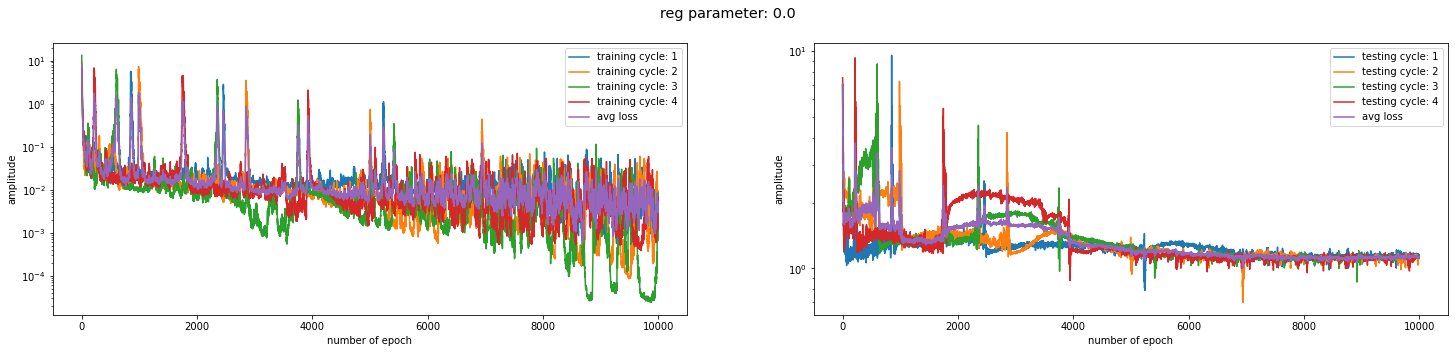

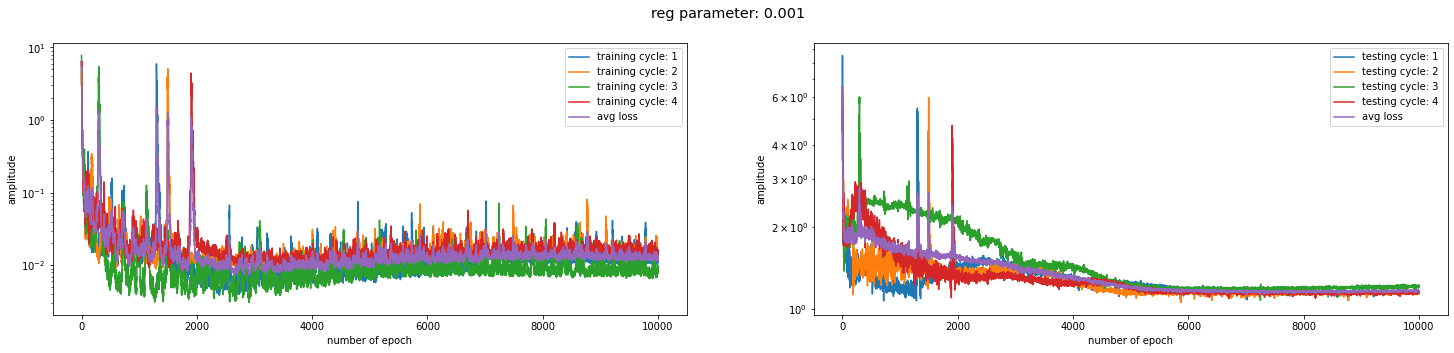

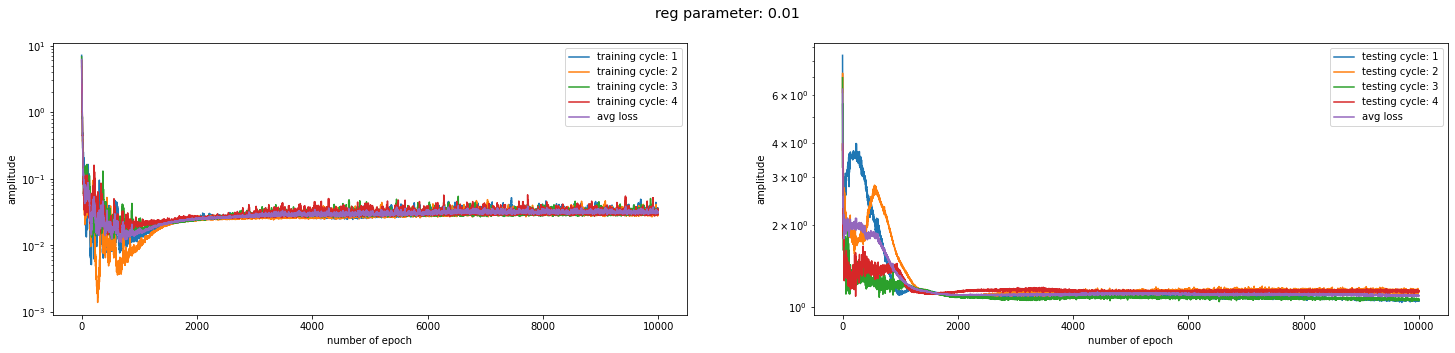

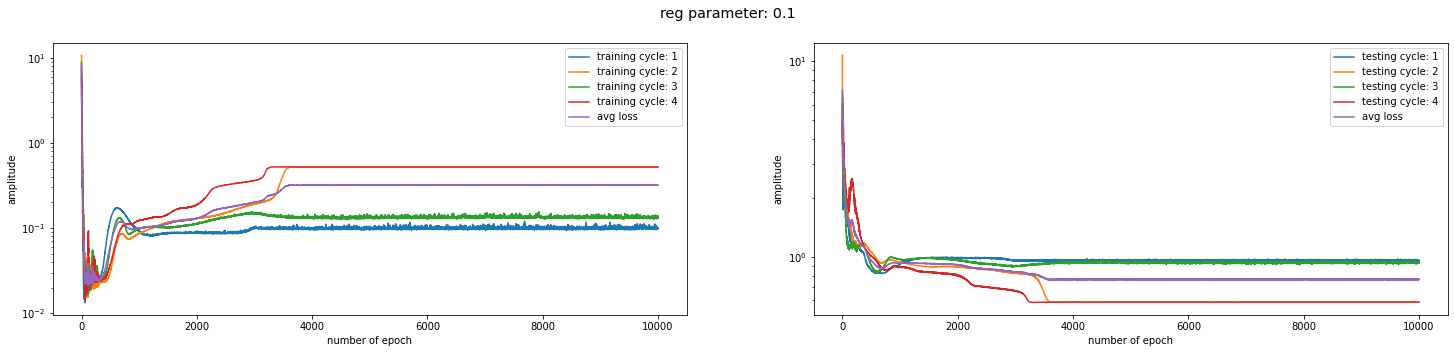

In [ ]:
avg_training_loss_array = [[] for i in range (len(reg)*4)]
avg_testing_loss_array = [[] for i in range (len(reg)*4)]

for m in range(4):
  for i in range(n_epoch):
    avg = 0
    for j in range(4):
      avg += training_loss_array[4*m+j][i]
    avg_training_loss_array[m].append(avg)


  
for m in range(4):
  for i in range(n_epoch):
    avg = 0
    for j in range(4):
      avg += testing_loss_array[4*m+j][i]
    avg_testing_loss_array[m].append(avg)


  avg_training_loss_array[m] = np.divide(avg_training_loss_array[m], len(training_loss_array)/4)
  avg_testing_loss_array[m] = np.divide(avg_testing_loss_array[m], len(testing_loss_array)/4)



for m in range(4):
  fig, ax = plt.subplots(1, 2, figsize=(25, 5))
  fig.suptitle("reg parameter: {}".format(reg[m]),fontsize = 'x-large')
  for k in range(4):
    ax[0].plot(list(range(n_epoch)), training_loss_array[4*m], label='training cycle: {}'.format(k+1))
    ax[0].plot(list(range(n_epoch)), training_loss_array[4*m+1], label='training cycle: {}'.format(k+2))
    ax[0].plot(list(range(n_epoch)), training_loss_array[4*m+2], label='training cycle: {}'.format(k+3))
    ax[0].plot(list(range(n_epoch)), training_loss_array[4*m+3], label='training cycle: {}'.format(k+4))
    ax[0].plot(list(range(n_epoch)), avg_training_loss_array[m],label='avg loss')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('number of epoch')
    ax[0].set_ylabel('amplitude')
    ax[0].legend()


    ax[1].plot(list(range(n_epoch)), testing_loss_array[4*m], label='testing cycle: {}'.format(k+1))
    ax[1].plot(list(range(n_epoch)), testing_loss_array[4*m+1], label='testing cycle: {}'.format(k+2))
    ax[1].plot(list(range(n_epoch)), testing_loss_array[4*m+2], label='testing cycle: {}'.format(k+3))
    ax[1].plot(list(range(n_epoch)), testing_loss_array[4*m+3], label='testing cycle: {}'.format(k+4))
    ax[1].plot(list(range(n_epoch)), avg_testing_loss_array[m],label='avg loss')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('number of epoch')
    ax[1].set_ylabel('amplitude')
    ax[1].legend()
    

    plt.show()


# for idx2, W2 in enumerate(width):
#   model = neuralnetwork(input_dim=1, width=W2, output_dim=1, depth=15, activation="sin")
#   y = model(x).squeeze(1).detach().numpy()
# # y = model(x).detach().numpy()
#   ax[idx2].plot(x.squeeze(1).numpy(),y, color= 'red')
#   ax[idx2].title.set_text('Plot '+str(idx2+5) +': sin plot with width = '+ str(W2))

In [ ]:
print('For reg param = 0, the last value of training and testing metrics at the final epoch are {}'.format(avg_training_loss_array[0][-1]), 'and {}'.format(avg_testing_loss_array[0][-1]))
print('For reg param = 0.001, the last value of training and testing metrics at the final epoch are {}'.format(avg_training_loss_array[1][-1]), 'and {}'.format(avg_testing_loss_array[1][-1]))
print('For reg param = 0.01, the last value of training and testing metrics at the final epoch are {}'.format(avg_training_loss_array[2][-1]), 'and {}'.format(avg_testing_loss_array[2][-1]))
print('For reg param = 0.1, the last value of training and testing metrics at the final epoch are {}'.format(avg_training_loss_array[3][-1]), 'and {}'.format(avg_testing_loss_array[3][-1]))

For reg param = 0, the last value of training and testing metrics at the final epoch are 0.0049784952570917085 and 1.1189837753772736
For reg param = 0.001, the last value of training and testing metrics at the final epoch are 0.012190810346510261 and 1.1709931194782257
For reg param = 0.01, the last value of training and testing metrics at the final epoch are 0.03188300132751465 and 1.1017538905143738
For reg param = 0.1, the last value of training and testing metrics at the final epoch are 0.3184534693136811 and 0.767822265625


6(b): 

In this case, We should pick the the lowest value of testing error function which would be the reg parameter = 0.1. However, by looking at the plot, the standard deviation of reg param = 0.1 seems larger than the rest conditions. Some testing results are exceptionally well. This should be further discussed in the next section.

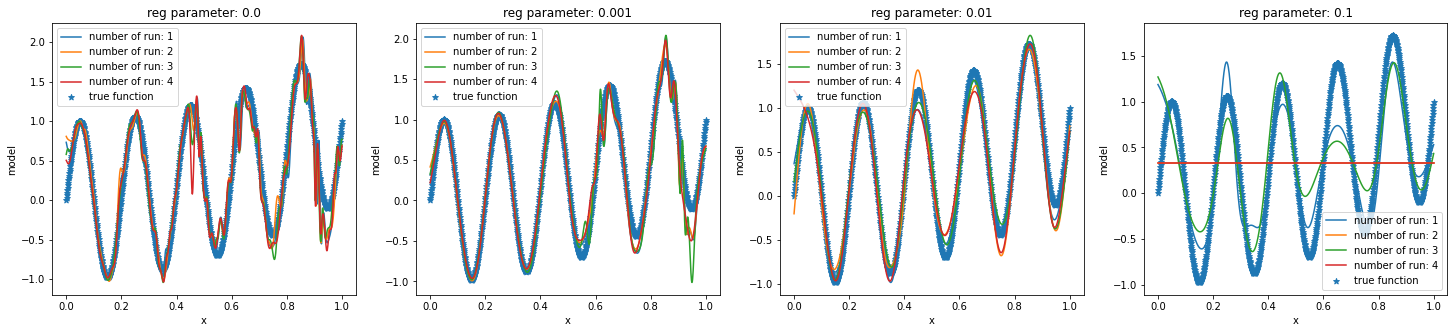

In [ ]:
from ctypes import pointer
x = torch.linspace(0,1,steps=1000).unsqueeze(1)


def true_function(var):
  # true function
  y = var**2 + torch.sin(10*torch.pi*var.clone().detach())
  return y

fig, ax = plt.subplots(1, 4, figsize=(25, 5))
for m in range(4):
  ax[m].scatter(x, true_function(x).detach(), label = 'true function', marker='*')
  # fig.suptitle("reg parameter: {}".format(reg[m]),fontsize = 'x-large')
  for i in range(4):
    ax[m].plot(x, model_array[m*4+i](x).detach(), label = 'number of run: {}'.format(i+1))
    ax[m].set_xlabel('x')
    ax[m].set_ylabel('model')
    ax[m].legend()
    ax[m].title.set_text("reg parameter: {}".format(reg[m]))

plt.show()

Comment on different reg parameters:

  Generally, the weight decay is to add a small penalty to the loss function. This is going to help prevent overfitting. In the first case (reg. param = 0), since no weight decay is added, the training process become very unsteady even at large number of epochs. This could be the reason of overfitting. 
  
  
  For the rest cases with different reg parameters, the best performance is when reg. parameter = 0.01. This is contradictory to our conclusion in 6(b). The reason will be explain in next paragraph. For reg param = 0.001, our model seems very complex and becomes overfitting again against the true function. Therefore, the model predictions are somehow similar to the case of reg param = 0. 


ref: https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9



---



Comment on reg. parameter = 0.1:
 
  In some cases, the predicted model is simply a constant value, no longer a sine wave. The reason is that all the weights are trained to zero, only bias left because the regularization process doesn't let the weights grow. Through the optimization, the weight metrics approach to zero. Then the derivative of the outputs respective to inputs would be zero, giving a flat line. For some are not flat, it reaches local minima instead.




